In [1]:
#IMPORTS 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import resize
from skimage.morphology import label


#IMPORT OWN FILES
import sys
sys.path.append(r"Code") # append folder "/Code" to our path"
import molecules as mc
import img3dto2d as i32
import stats as st
import video_format as vf

## Select simulation to test post processing on

In [2]:
# load radius and all molecule positions
filename = r"Data\6P\simV3R_1000_8000_1224_9_1000_89542.npy" #name, num frames saved, boxsize x and y, seed, stepsize, frames skiped, uniqe chars
filename_split = filename.split("_")
points, radii, acc = mc.load_molecule_steps(filename)

#sim values:
num_frames = int(filename_split[1]) #can be stored at eg. 100 steps pr frame (to save space)
num_molecules = len(points[0])
size_const = int(filename_split[2])
seed = int(filename_split[3])
max_stepsize =  int(filename_split[4])
skip_frames = int(filename_split[5])
box_size = np.array([size_const,size_const,1000]) #may need to set the z value to differently

#image values
image_size = np.array([size_const,size_const])
sigma_smooth = 175 #gauss smoothing
smooth_th = 0.55 #threshold for inital image

frames = [0,len(points) - 1] #select frames to plot
print("total frames", num_frames * skip_frames, "stored frames:" , num_frames, "molecules:",  num_molecules ," image size:", image_size , "seed:",seed, "max stepsize:",max_stepsize)
print("acc mean:", np.mean(acc))

#volume fraciton:
box_vol = int(box_size[0])*int(box_size[1])*int(box_size[2])
sphere_vol = 0
for r in radii:
  sphere_vol += ((4/3)*r**3*np.pi)

print("Density: ", sphere_vol/box_vol)

total frames 1000000 stored frames: 1000 molecules: 479  image size: [8000 8000] seed: 1224 max stepsize: 9
acc mean: 0.391827
Density:  0.06298836026253886


## Projection

0it [00:00, ?it/s]

2it [01:28, 44.14s/it]


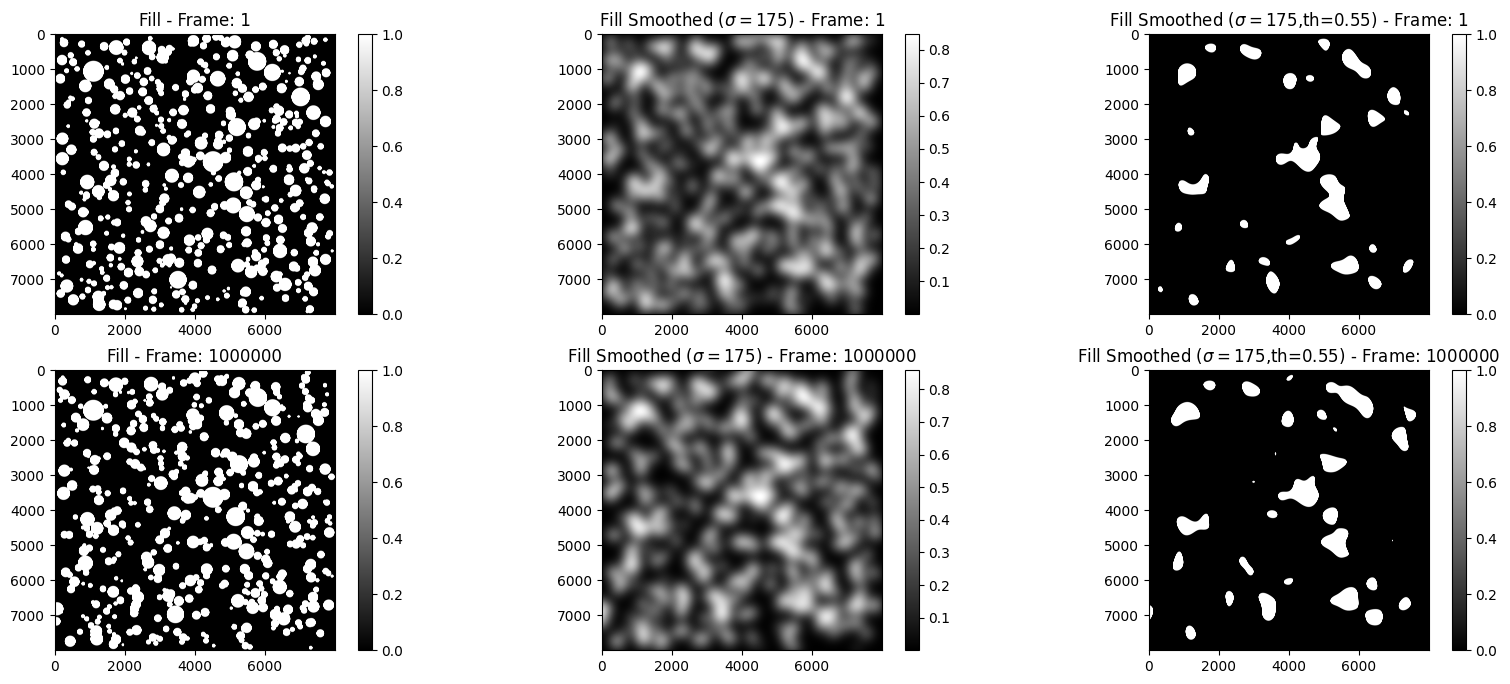

In [3]:
imgs_fill = []
imgs_fill_smooth = []

num_cols = 3

plt.figure(figsize=(20,4*len(frames)))
for i,f in tqdm(enumerate(frames)):
  
  _p2dr = list(zip(np.array(points[f])[:,:2],radii)) # all depths

  _frame_val = f #this conversion probably works best for first and last frame (may need the verify)
  if f == 0:
    _frame_val = 1
  else:
    _frame_val = (_frame_val + 1) * skip_frames

  #Hard fill
  plt.subplot(len(frames),num_cols,(i)*num_cols+1)
  plt.title(f"Fill - Frame: {_frame_val}")
  _img_fill = i32.get_3d_to_2d_img(_p2dr,image_size)

  im_ratio = _img_fill.shape[0]/_img_fill.shape[1]
  plt.imshow(_img_fill,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

  #gauss on hard fill:
  plt.subplot(len(frames),num_cols,(i)*num_cols+2)
  plt.title(f"Fill Smoothed ($\sigma =${sigma_smooth}) - Frame: {_frame_val}")
  _img_smooth = i32.gauss2dimg(_img_fill,sigma_smooth)
  plt.imshow(_img_smooth,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

  #gauss on hard fill thresholded
  plt.subplot(len(frames),num_cols,(i)*num_cols+3)
  plt.title(f"Fill Smoothed ($\sigma =${sigma_smooth},th={smooth_th}) - Frame: {_frame_val}")
  _img_smooth_th = np.where(_img_smooth > smooth_th,1,0)
  plt.imshow(_img_smooth_th,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)


  imgs_fill.append(_img_fill)
  imgs_fill_smooth.append(_img_smooth)

plt.show()

## Test various thresholds

cells start 1 Cells end: 1
start area fraction ours: 0.90546875
end area fraction ours: 0.86921875


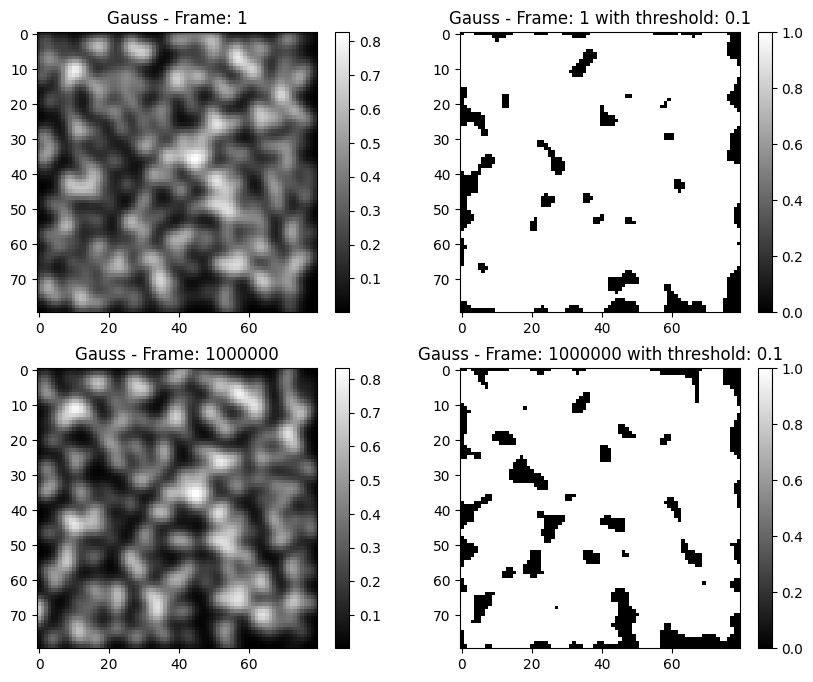

cells start 3 Cells end: 5
start area fraction ours: 0.69796875
end area fraction ours: 0.636875


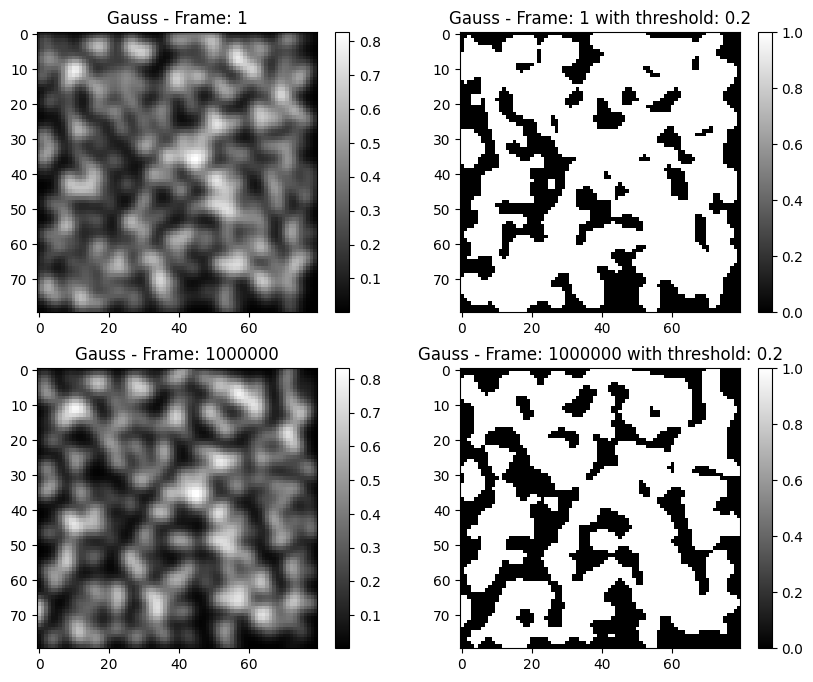

cells start 17 Cells end: 24
start area fraction ours: 0.433125
end area fraction ours: 0.41328125


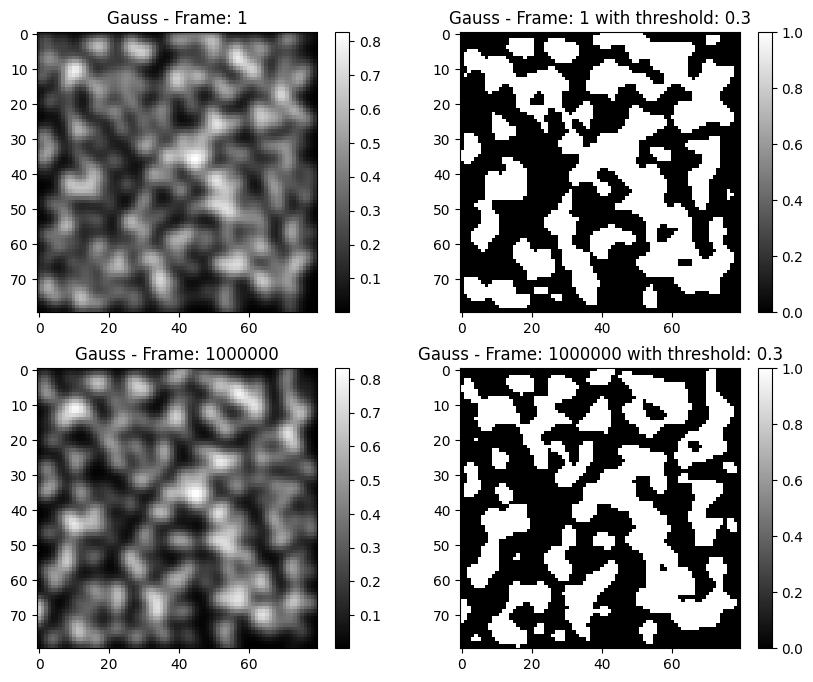

cells start 34 Cells end: 34
start area fraction ours: 0.2275
end area fraction ours: 0.22890625


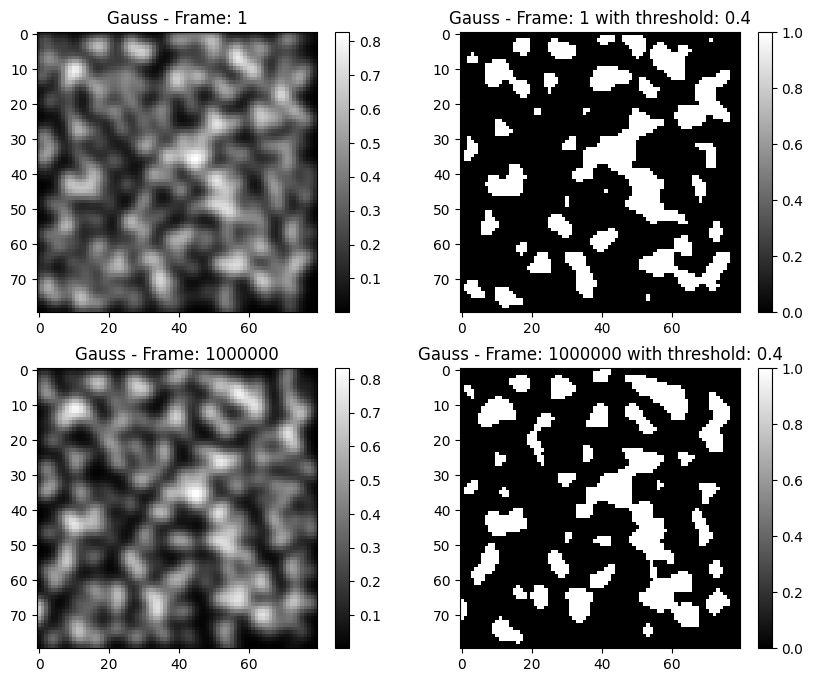

cells start 30 Cells end: 34
start area fraction ours: 0.10359375
end area fraction ours: 0.11140625


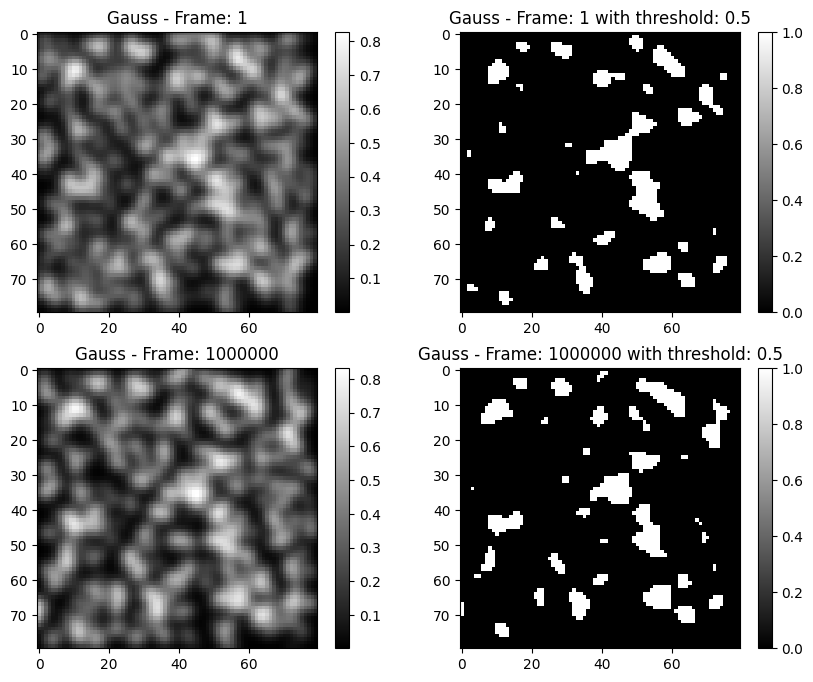

cells start 17 Cells end: 22
start area fraction ours: 0.035
end area fraction ours: 0.04625


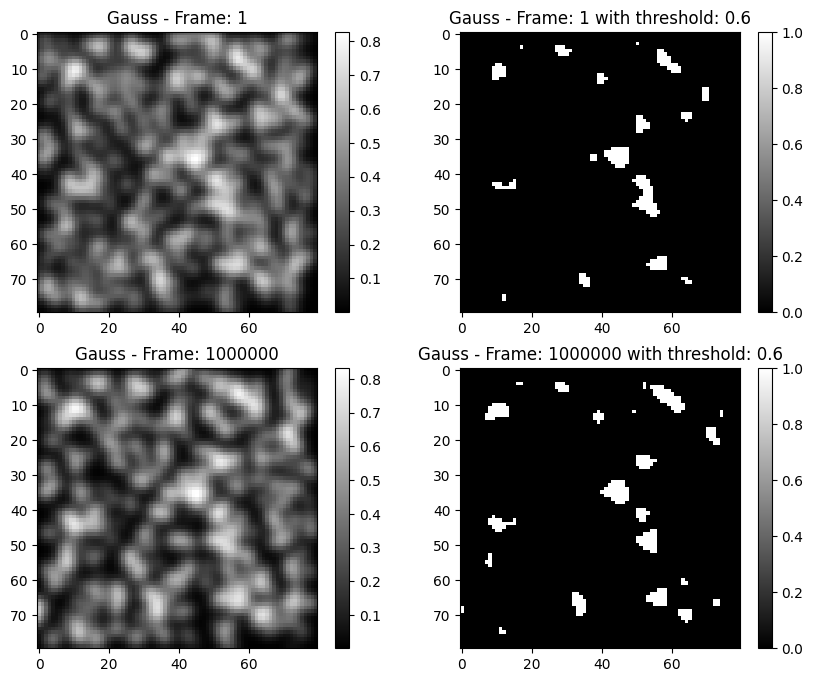

cells start 7 Cells end: 11
start area fraction ours: 0.00640625
end area fraction ours: 0.0125


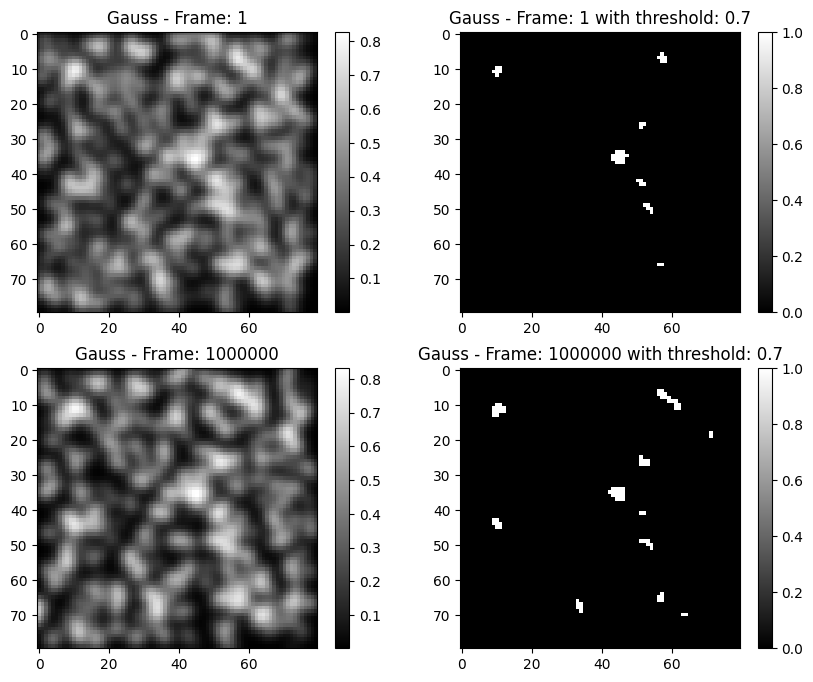

cells start 1 Cells end: 2
start area fraction ours: 0.00046875
end area fraction ours: 0.0009375


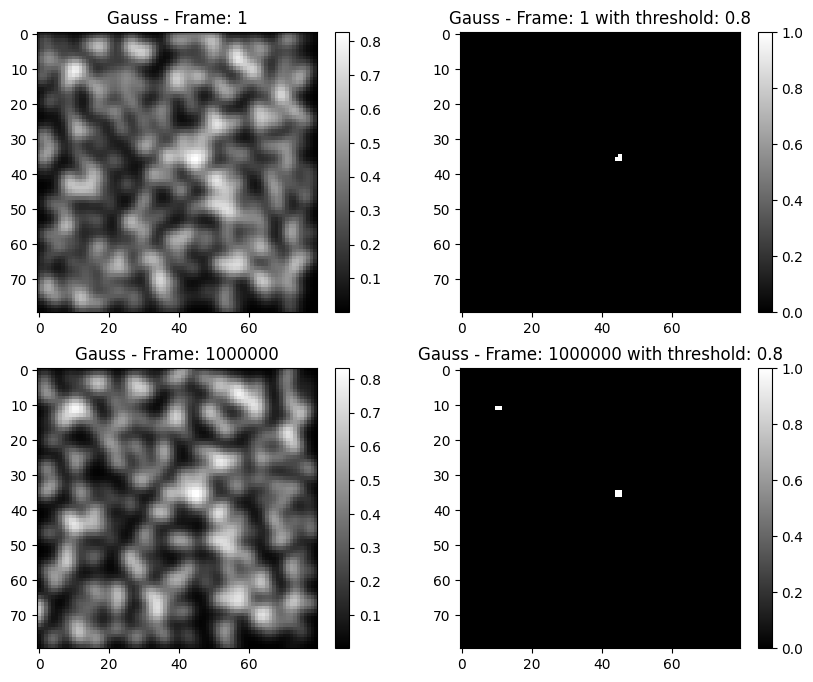

cells start 0 Cells end: 0
start area fraction ours: 0.0
end area fraction ours: 0.0


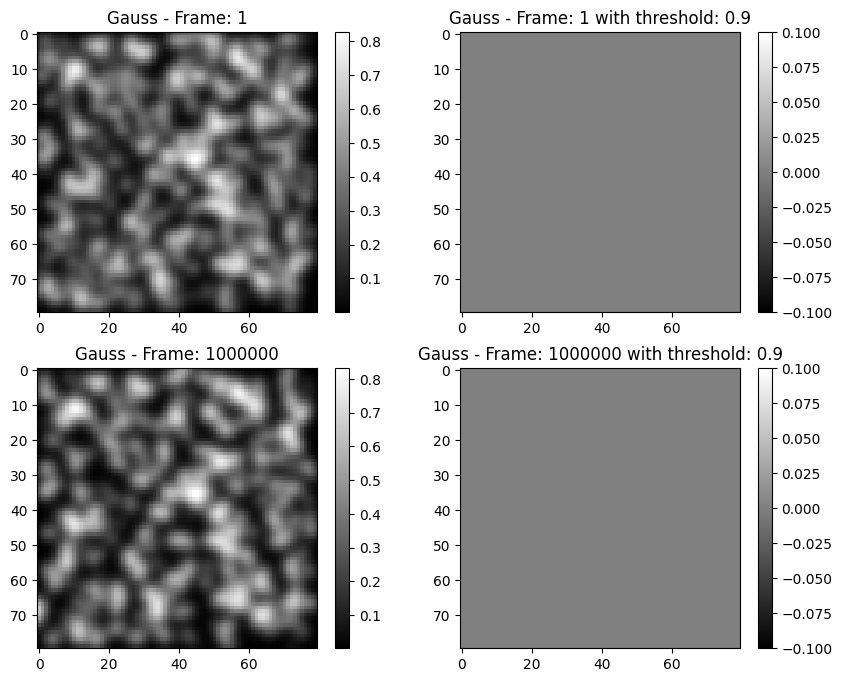

cells start 0 Cells end: 0
start area fraction ours: 0.0
end area fraction ours: 0.0


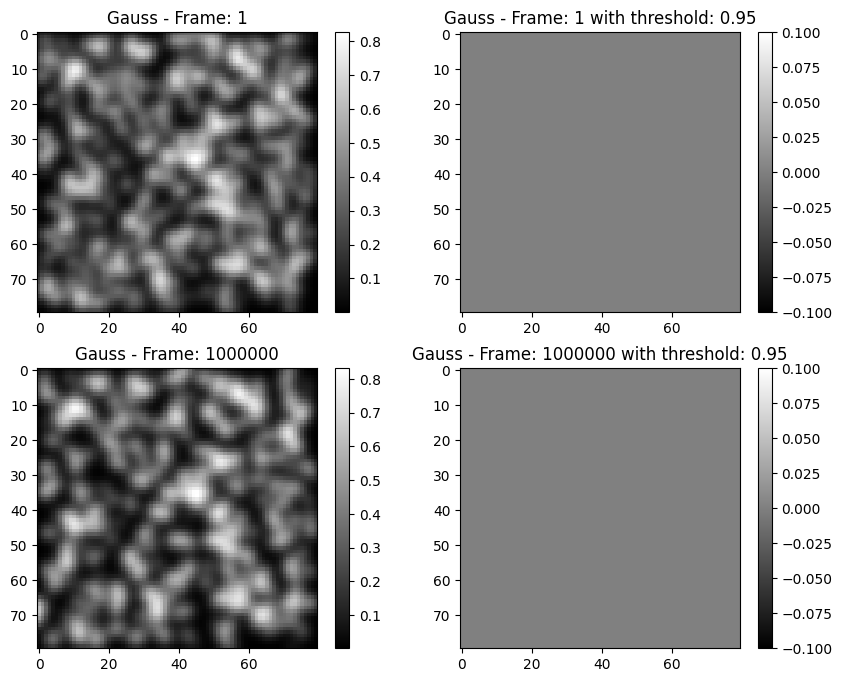

In [4]:
#image stuff:
def process_our_image(img):
  #need to smooth?
  #remove boarder?
  return label(img)

L= 50

#thresholds:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]

wanted_image_size = np.array([400,400]) #video size
scaled_img_size = np.array([box_size[0]/100,box_size[1]/100]) #1 pixel in original video is 100 nm

dupX = int(wanted_image_size[1]/scaled_img_size[1])
dupY = int(wanted_image_size[0]/scaled_img_size[0])

image_frames = [resize(i,scaled_img_size) for i in imgs_fill_smooth]

for threshold in thresholds:
  th_imgs = []

  plt.figure(figsize=(10,4*len(image_frames)))
  for i,img in enumerate(image_frames):

    _frame_val = frames[i] #this conversion probably works best for first and last frame (may need the verify)
    if frames[i] == 0:
      _frame_val = 1
    else:
      _frame_val = (_frame_val + 1) * skip_frames

    plt.subplot(len(imgs_fill),2,(i)*2+1)
    plt.title(f"Gauss - Frame: {_frame_val}")
    plt.imshow(img,cmap="gray")

    im_ratio = img.shape[0]/img.shape[1]
    plt.colorbar(fraction=0.045 * im_ratio)

    plt.subplot(len(imgs_fill),2,(i)*2+2)
    plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
    _img_gauss_th = np.where(img > threshold,1,0)
    plt.imshow(_img_gauss_th,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    th_imgs.append(_img_gauss_th)
  

  #apply connected components
  cc_imgs = [process_our_image(i) for i in th_imgs]
  print("cells start",max(np.unique(cc_imgs[0])), "Cells end:", max(np.unique(cc_imgs[-1])))
  print("start area fraction ours:", np.sum(np.where(cc_imgs[0]> 0, 1, 0)) / (scaled_img_size[0]*scaled_img_size[1]))
  print("end area fraction ours:", np.sum(np.where(cc_imgs[-1]> 0, 1, 0)) / (scaled_img_size[0]*scaled_img_size[1]))

  plt.show()

## Select specific threshold and compute the RSM

In [5]:
import numpy as np
# import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.color import label2rgb
from IPython.display import display, clear_output

#adapted from the bachelor paper
def visualize2(video, F_list, G_list, F_noise=np.array([]), G_noise=np.array([]), L=100, save=False,frame_name = "-1"):
    """Visualizes a list of data overlaps, can compare with one dataset"""
    fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    plt.tight_layout()
    plt.title('Cheese gel video frames')
    colors = cm.Blues(np.linspace(0.2, 1, len(video)))

    # a = int(168 / len(video))

    for i in range(len(F_list)):
        M = video[i].shape[0] - L
        bx = (L, M, M, L, L)
        by = (L, L, M, M, L)

        ax[3].plot(bx, by, '-r')
        ax[3].imshow(label2rgb(video[i], bg_label=0))
        # ax[3].set_title('frame nr.{}'.format(a * (i+1)))
        if frame_name == "-1":
            ax[3].set_title('frame nr.{}'.format(i+1))
        else:
            ax[3].set_title(f'frame nr. {frame_name}')

        ax[0].set_title('Area overlap')
        ax[0].plot(F_list[i], color=colors[i])
        ax[0].set_xlabel('r')
        ax[0].set_ylabel('area overlap')

        ax[1].set_title('Fractional area overlap')
        ax[1].plot(F_list[i]/G_list[i], color=colors[i])
        ax[1].set_xlabel('r')
        ax[1].set_ylabel('fractional area overlap')

        ax[2].set_title('Curve overlap')
        ax[2].plot((F_list[i])[1:]-(F_list[i])[:-1], color=colors[i])
        ax[2].set_xlabel('r')
        ax[2].set_ylabel('curve overlap')

        if save:
            # filename = 'frames/subplot_{:03d}.png'.format(a * (i+1))
            filename = 'frames/subplot_{:03d}.png'.format(i+1)
            fig.savefig(filename)
            # plots.append(fig)

        #clear_output(wait = True)

    if F_noise.size and G_noise.size:
        ax[0].plot(F_noise, color='r')
        ax[1].plot(F_noise/G_noise, color='r')
        ax[2].plot(F_noise[1:]-F_noise[:-1], color='r')

    if save:
        # filename = 'frames/subplot_{:03d}.png'.format(a * (i+1))
        filename = 'frames/subplot_{:03d}.png'.format(i+1)
        fig.savefig(filename)
        # plots.append(fig)

        # with imageio.get_writer('animation.gif', mode='I') as writer:
        #     for plot in plots:
        #         writer.append_data(imageio.core.image_as_uint(plot.canvas.renderer.buffer_rgba()))
    plt.show()

5 5


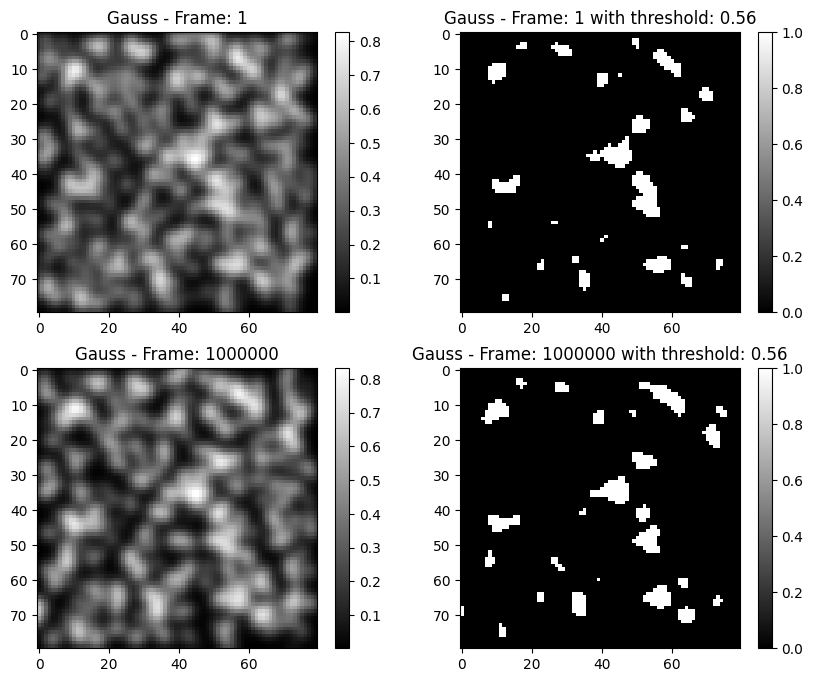

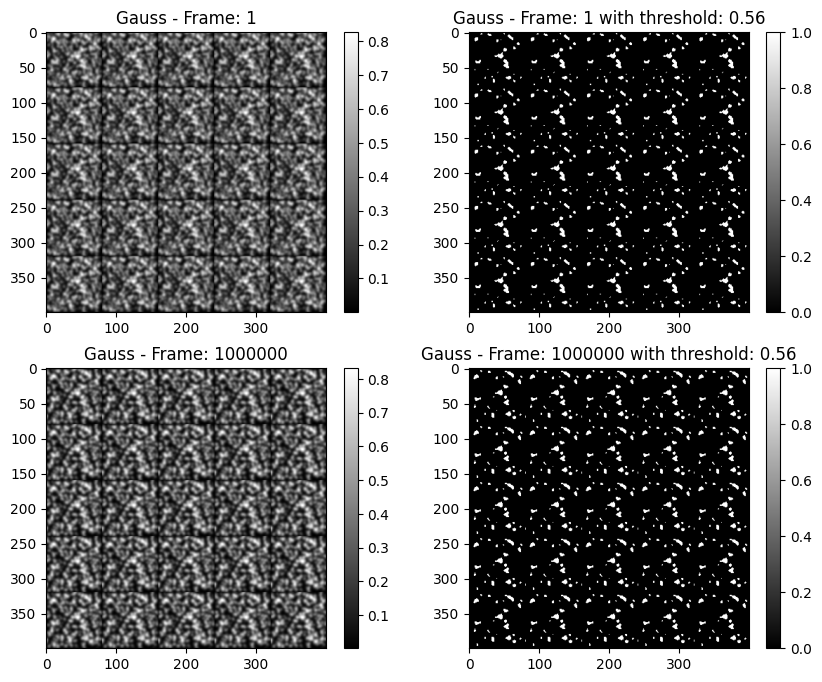

cells start 600 Cells end: 625
start area fraction ours: 0.05796875
end area fraction ours: 0.06984375


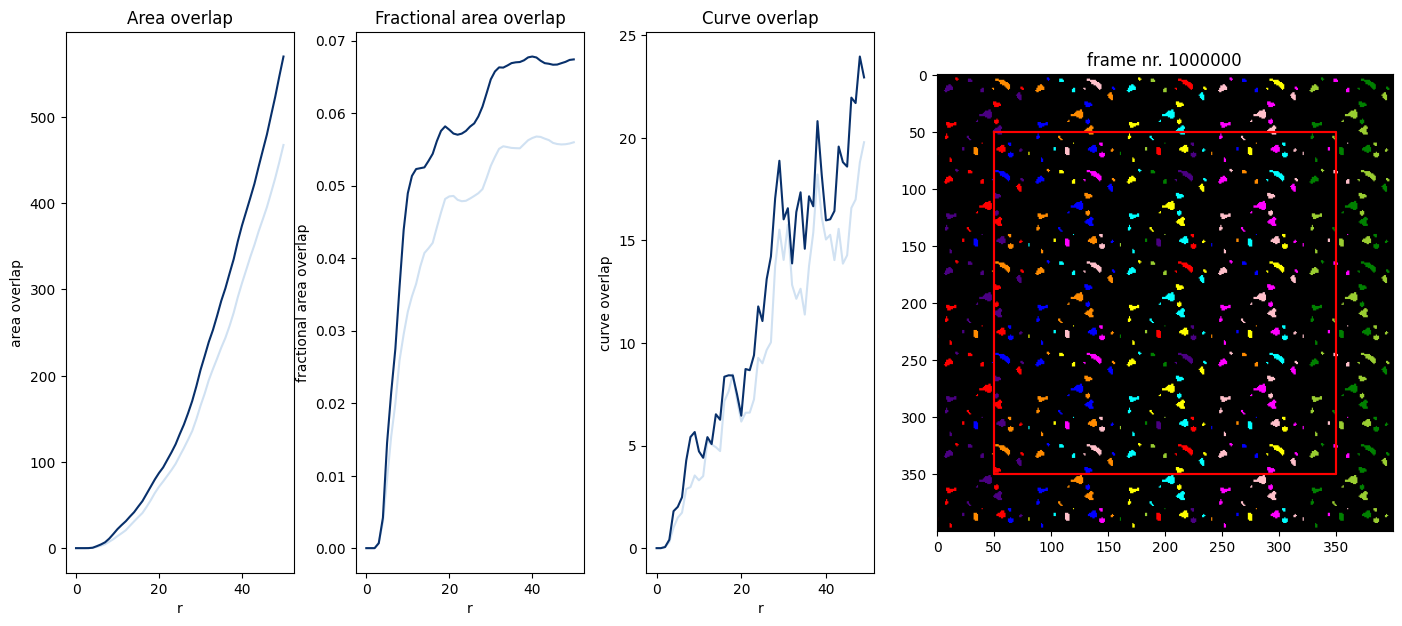

In [6]:
def process_our_image(img):
  #need to smooth?
  #remove boarder?
  return label(img)

L= 50

#apply threshold:
threshold = 0.56#0.81

wanted_image_size = np.array([400,400]) #video size
scaled_img_size = np.array([box_size[0]/100,box_size[1]/100]) #1 pixel in original video is 100 nm

dupX = int(wanted_image_size[1]/scaled_img_size[1])
dupY = int(wanted_image_size[0]/scaled_img_size[0])
print(dupX,dupY)

image_frames = [resize(i,scaled_img_size) for i in imgs_fill_smooth]
image_frames_duplicated = [i32.duplicate_image(img,dupX,dupY) for img in image_frames]

th_imgs = []


plt.figure(figsize=(10,4*len(image_frames)))
for i,img in enumerate(image_frames):

  _frame_val = frames[i] #this conversion probably works best for first and last frame (may need the verify)
  if frames[i] == 0:
    _frame_val = 1
  else:
    _frame_val = (_frame_val + 1) * skip_frames

  plt.subplot(len(imgs_fill),2,(i)*2+1)
  plt.title(f"Gauss - Frame: {_frame_val}")
  plt.imshow(img,cmap="gray")

  im_ratio = img.shape[0]/img.shape[1]
  plt.colorbar(fraction=0.045 * im_ratio)

  plt.subplot(len(imgs_fill),2,(i)*2+2)
  plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
  _img_gauss_th = np.where(img > threshold,1,0)
  plt.imshow(_img_gauss_th,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

plt.show()



plt.figure(figsize=(10,4*len(image_frames)))
for i,img in enumerate(image_frames_duplicated):#enumerate(image_frames):

  _frame_val = frames[i] #this conversion probably works best for first and last frame (may need the verify)
  if frames[i] == 0:
    _frame_val = 1
  else:
    _frame_val = (_frame_val + 1) * skip_frames

  plt.subplot(len(imgs_fill),2,(i)*2+1)
  plt.title(f"Gauss - Frame: {_frame_val}")
  plt.imshow(img,cmap="gray")

  im_ratio = img.shape[0]/img.shape[1]
  plt.colorbar(fraction=0.045 * im_ratio)

  plt.subplot(len(imgs_fill),2,(i)*2+2)
  plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
  _img_gauss_th = np.where(img > threshold,1,0)
  plt.imshow(_img_gauss_th,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

  th_imgs.append(_img_gauss_th)
plt.show()

#apply connected components
cc_imgs = [process_our_image(i) for i in th_imgs]

print("cells start",max(np.unique(cc_imgs[0])), "Cells end:", max(np.unique(cc_imgs[-1])))
print("start area fraction ours:", np.sum(np.where(cc_imgs[0]> 0, 1, 0)) / (400*400))
print("end area fraction ours:", np.sum(np.where(cc_imgs[-1]> 0, 1, 0)) / (400*400))

F_list, G_list = vf.analyse_video(cc_imgs,L=L)
visualize2(cc_imgs,F_list,G_list, save=False,L=L,frame_name="1000000")